Import Necessary Modules

In [1]:
from xml.dom import minidom
import re
import numpy as np
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import math
from random import randint

Data Cleaning

In [2]:
TAG_RE = re.compile(r'<[^>]+>|\'')
def remove_tags(text):
    return TAG_RE.sub('', text)

PUNC_TAG = re.compile(r'[^a-zA-Z0-9_]')
def remove_punctuation(text):
    return PUNC_TAG.sub(' ', text)

Spaces = re.compile(r'  *')
def remove_spaces(text):
    return Spaces.sub(' ', text)

def remove_junk(string):
    return (remove_spaces(remove_punctuation(remove_tags(string)))).lower()


In [3]:
# https://github.com/Alir3z4/stop-words/blob/master/english.txt
file = open('english.txt', 'r')
stopwords = []

for i in file.readlines():
    i = i.split()
    stopwords = stopwords + i

file.close()

In [4]:
# https://gist.github.com/mmmayo13/07252b4eb27e5495b6032888b38e5333#file-text_data_preprocessing_5-py
def stem_word(word):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()   
    return stemmer.stem(word)

def lemmatize_verb(word):
    """Lemmatize verbs"""
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word, pos='v')

def lemm(word):
    """Lemmatize nouns"""
    wordnet_lemmatizer = WordNetLemmatizer()
    return wordnet_lemmatizer.lemmatize(word)

def pot(word):
    porter_stemmer = PorterStemmer()
    return porter_stemmer.stem(word)


In [5]:
def build_wordlist(filelocation, stopwords, wordmap, index, MAX_ROWS = 200):
    
    # parse an xml file by name
    mydoc = minidom.parse(filelocation)
    
    # get each row in the file
    items = mydoc.getElementsByTagName('row')
    count=0
    
    for item in items:
        
        # remove unnecessary things
        string = remove_junk(item.attributes['Body'].value)
        
        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break
        
        # check every single words in the string
        words = string.split(" ")
        
        for word in words:
            
            # check whether it's an important word or not
            # https://docs.python.org/3/library/stdtypes.html#str.isnumeric
            if not word.isnumeric() and len(word) > 1:
                # lemmatize the words 
                word = lemm(lemmatize_verb(word))
                
                if word not in wordmap and word not in stopwords:
                    
                    wordmap[word] = index
                    index = index + 1

    
    return wordmap, index


In [6]:
def vectormapping_train(filelocation, wordmap, MAX_ROWS = 200):

    count = 0
    
    # initialize the vector
    vector = [0]*len(wordmap)
    
    testdoc = minidom.parse(filelocation)
    testItems = testdoc.getElementsByTagName('row')

    for testItem in testItems:
        
        # okay, remove the junk as before
        string = remove_tags(testItem.attributes['Body'].value)
        string = remove_punctuation(string)
        string = remove_spaces(string)
        string = string.lower()

        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break
        
        
        # check every words in the string
        words = string.split(" ")
        
        # now go through every word
        for w in words:
            # lemmatize the word
            if not w.isnumeric() and len(w) > 1 and w not in stopwords:

                w = lemm(lemmatize_verb(w))

                # count how many times it's in the string
                if w in wordmap.keys():
                    vector[wordmap[w]]=vector[wordmap[w]]+1

        # append this vector of a single row to the whole vector list
        # mainvec.append(vector)

    return vector


In [7]:
def vectormapping_train_cos(filelocation, wordmap, MAX_ROWS = 200):

    count = 0
    mainvec =[]
    
    testdoc = minidom.parse(filelocation)
    testItems = testdoc.getElementsByTagName('row')

    for testItem in testItems:
        
        # initialize the vector
        vector = [0]*len(wordmap)
        
        # okay, remove the junk as before
        string = remove_tags(testItem.attributes['Body'].value)
        string = remove_punctuation(string)
        string = remove_spaces(string)
        string = string.lower()

        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break
        
        # check every words in the string
        words = string.split(" ")
        
        # now go through every word
        for w in words:
            # lemmatize the word
            if not w.isnumeric() and len(w) > 1 and w not in stopwords:

                w = lemm(lemmatize_verb(w))

                # count how many times it's in the string
                if w in wordmap.keys():
                    vector[wordmap[w]]=vector[wordmap[w]]+1

        # append this vector of a single row to the whole vector list
        mainvec.append(vector)

    return mainvec


In [8]:
def vectormapping_test(filelocation, wordmap, row_number, MAX_ROWS = 200):

    count = 0
    mainvec = []
    notinwordmap = []
    extwordmap = []
    
    testdoc = minidom.parse(filelocation)
    testItems = testdoc.getElementsByTagName('row')
    
    for testItem in row_number:
        
        # initialize the vector
        vector = [0]*len(wordmap)
        notinmap = []
        extmap = []
        
        # okay, remove the junk as before
        string = remove_tags(testItems[testItem].attributes['Body'].value)
        string = remove_punctuation(string)
        string = remove_spaces(string)
        string = string.lower()
        
        # not count a paragraph without any value
        if len(string) < 2:
            continue
        
        count=count+1
        if count==MAX_ROWS:
            break
        
        # check every words in the string
        words = string.split(" ")
        
        # now go through every word
        for w in words:
            
            # lemmatize the word
            if not w.isnumeric() and len(w) > 1 and w not in stopwords:
                w = lemm(lemmatize_verb(w))
                # print(w)
            
            # count how many times it's in the string
                if w in wordmap.keys():
                    vector[wordmap[w]]=vector[wordmap[w]]+1
                else:
                    notinmap.append(w)
        
        # https://stackoverflow.com/questions/12282232/how-do-i-count-unique-values-inside-a-list
        # extmap = list(set(notinmap))
        extmap = (np.unique(notinmap, return_counts=True)[0]).tolist()
        notinmap = (np.unique(notinmap, return_counts=True)[1]).tolist()

        # append this vector of a single row to the whole vector list
        mainvec.append(vector)
        notinwordmap.append(notinmap)
        extwordmap.append(extmap)
        
        
    return mainvec, notinwordmap, extwordmap


In [9]:
# if we need the total wordmap in a list....
def features_name(wordmap):

    features = [0] * len(wordmap)

    for i in range(len(wordmap)):
            for w, c in wordmap.items():
                if i == c:
                    features[i] = w
    return features

# Functions for Naive Bayes

In [10]:
def naive_bayes(total_vector, test_vector, extvector, names, alpha, V):
    probability_names = [1]*len(names)
    
    for name in range(len(names)):
        Ncm = sum(total_vector[name]) + (alpha * V)
        probability_names[name] *= math.pow((alpha/Ncm), len(extvector))
        for i in range(len(test_vector)):
            if test_vector[i]:
                probability_names[name] *= ((total_vector[name, i] + alpha) / Ncm)
            
                
    # print(probability_names)
    return names[np.argmax(probability_names)]
    

def actual_result_from_id(names, total_numbers, TEST_MAX_ROWS):
    val = TEST_MAX_ROWS
    for i in range(0,len(names)):
        if total_numbers < val:
            return names[i]
        
        else:
            val = val + TEST_MAX_ROWS


def naive(wordmap, rows, names, total_vector, TEST_MAX_ROWS):
    
    test_vectors = []
    extvector = []
    extwordmap = []

    accurate = 0
    total_numbers = 0
    V = len(wordmap)
    alpha = 0.1233


    for name in names:
        fileloc = './Dataset/Test/' + name + '.xml'
        # print('>>>', name, end=' --')

        test_vectors += vectormapping_test(fileloc, wordmap, rows, TEST_MAX_ROWS + 1)[0]
        extvector += vectormapping_test(fileloc, wordmap, rows,TEST_MAX_ROWS + 1)[1]
        extwordmap += vectormapping_test(fileloc, wordmap, rows,TEST_MAX_ROWS + 1)[2]
        

    test_vectors = np.array(test_vectors)
    extvector = np.array(extvector)
    extwordmap = np.array(extwordmap)

    
    for i in range(len(test_vectors)):

        actual_result = actual_result_from_id(names, total_numbers, TEST_MAX_ROWS)
        predicted_result = naive_bayes(total_vector, test_vectors[i], extvector[i], names, alpha, V)

        total_numbers += 1
        # print(actual_result,"-->", predicted_result)
        if actual_result == predicted_result:
            accurate += 1

    return round((accurate/total_numbers) * 100, 3)


# Functions for Cosine Similarity

In [11]:
# prediction
def prediction(vec, KNN=5):
    
    row_indexes = np.argsort(-vec, axis=None)[:KNN]
    # print(row_indexes, end=' ->')
    predic = []
    for r in row_indexes:
        val = MAX_ROWS

        for i in range(0,len(names)):
            if r < val:
                predic.append(names[i])
                break
            else:
                val = val + MAX_ROWS

    b = np.unique(predic, return_counts=True)[1]
    c = np.argmax(b)
    for i in range(len(b)):
        if i != c and b[i] == b[c]:
            return predic[0]
    
    return np.unique(predic)[np.argmax(np.unique(predic, return_counts=True)[1])]


def cosine(wordmap, rows, names, total_vector_cos, TEST_MAX_ROWS):

    # Training
    idf_nu = len(total_vector_cos)
    tf_idf_train = np.array(total_vector_cos, dtype=np.float64)
    
    for i in range(len(total_vector_cos)):
        # print(total_vector[i])
        # print(i)
        tf_idf_train[i] = total_vector_cos[i] / sum(total_vector_cos[i])
        for j in range(len(total_vector_cos[i])):
            idf_de = 1 + len((total_vector_cos[:,j])[(total_vector_cos[:,j])>0])
            idf = math.log(idf_nu/idf_de)
            tf_idf_train[i, j] *= idf


    test_vectors = []
    extvector = []
    extwordmap = []

    for name in names:
        fileloc = './Dataset/Test/' + name + '.xml'

        test_vectors += vectormapping_test(fileloc, wordmap, rows, TEST_MAX_ROWS + 1)[0]
        extvector += vectormapping_test(fileloc, wordmap, rows,TEST_MAX_ROWS + 1)[1]
        extwordmap += vectormapping_test(fileloc, wordmap, rows,TEST_MAX_ROWS + 1)[2]


    test_vectors = np.array(test_vectors)
    extvector = np.array(extvector)
    extwordmap = np.array(extwordmap)

    
    
    
    # test data tf_idf vector creation
    idf_nu = len(total_vector_cos)
    tf_idf_test = np.array(test_vectors, dtype=np.float64)

    for i in range(len(test_vectors)):
        tf_idf_test[i] = test_vectors[i] / (sum(test_vectors[i]) + sum(extvector[i]))

        for j in range(len(test_vectors[i])):
            idf_de = 1 + len((total_vector_cos[:,j])[(total_vector_cos[:,j])>0])
            idf = math.log10(idf_nu/ idf_de)
            tf_idf_test[i, j] *= idf


    # not in wordlist
    idf = math.log(idf_nu)
    tf_idf_ext = np.empty([len(extvector), 1], dtype=np.float64)

    for i in range(len(extvector)):
        tf_idf_ext[i] = sum(((extvector[i] / (sum(test_vectors[i]) + sum(extvector[i]))) * idf) ** 2)

    accurate = 0
    total_numbers = 0

    KNN = 5

    for i in range(len(tf_idf_test)):
        numerator_set = np.multiply(tf_idf_train, tf_idf_test[i])
        denB = sum(tf_idf_test[i] ** 2) + tf_idf_ext[i]
        denA_set = tf_idf_train ** 2

        resulting_vec = np.empty((len(numerator_set), 1), dtype=float)
        for j in range(len(numerator_set)):
            resulting_vec[j] = sum(numerator_set[j]) / (math.sqrt(sum(denA_set[j])) * math.sqrt(denB))

        actual_result = actual_result_from_id(names, total_numbers, TEST_MAX_ROWS)
        predicted_result = prediction(resulting_vec, KNN)

        total_numbers += 1
        # print(actual_result,"-->", predicted_result)
        if actual_result == predicted_result:
            accurate += 1
    
    return round((accurate/total_numbers) * 100, 3)


# Wordmap

In [12]:
filenames = open('./Dataset/topics.txt', 'r')
names = []

for i in filenames.readlines():
    names = names + i.split()

print('>>files: ', names)

wordmap = {}
index = 0

MAX_ROWS = 80

# build the total wordMap of all the files and rows
for name in names:
    fileloc = './Dataset/Training/' + name + '.xml'
    wordmap, index = build_wordlist(fileloc, stopwords, wordmap, index, MAX_ROWS + 1)


print('>>wordmap generated')
print('>>total number of features:', len(wordmap))

>>files:  ['Coffee', 'Cooking', 'Law', 'Space', 'Windows_Phone', 'Wood_Working']
>>wordmap generated
>>total number of features: 4129


# Training Set Vectors

In [13]:
total_vector = []

# create a list of vectors of all the training datasets
for name in names:
    fileloc = './Dataset/Training/' + name + '.xml'
    print('>>', name, end='--')
    total_vector.append(vectormapping_train(fileloc, wordmap, MAX_ROWS + 1)) 
    print('Done')

total_vector = np.array(total_vector)

total_vector_cos = []

# create a list of vectors of all the training datasets
for name in names:
    fileloc = './Dataset/Training/' + name + '.xml'
    print('>>', name, end='--')
    total_vector_cos = total_vector_cos + vectormapping_train_cos(fileloc, wordmap, MAX_ROWS + 1)
    print('Done')

total_vector_cos = np.array(total_vector_cos)


>> Coffee--Done
>> Cooking--Done
>> Law--Done
>> Space--Done
>> Windows_Phone--Done
>> Wood_Working--Done
>> Coffee--Done
>> Cooking--Done
>> Law--Done
>> Space--Done
>> Windows_Phone--Done
>> Wood_Working--Done


Compare between Naive Bayes and Cosine Similarity

In [14]:
file = open('best classifiers.txt', 'w')
file.write('Naive Bayes \tCosine Simialrity\n')


TRIES = 10
accuracy_naive = [0 for i in range(0, TRIES)]
accuracy_cosine = [0 for i in range(0, TRIES)]


TEST_MAX_ROWS = 20

avg_naive = 0
avg_cosine = 0


print("Naive Bayes\tCosine Similarity")
for j in range(0, TRIES):

    # https://docs.python.org/3/library/random.html#random.randint
    # https://stackoverflow.com/questions/3996904/generate-random-integers-between-0-and-9
    rows = [randint(0, 70) for p in range(0, TEST_MAX_ROWS)]
    # print(rows)


    accuracy_naive[j] = naive(wordmap, rows, names, total_vector, TEST_MAX_ROWS)
    file.write(str(accuracy_naive[j]))
    
    accuracy_cosine[j] = cosine(wordmap, rows, names, total_vector_cos, TEST_MAX_ROWS)
    file.write('\t\t'+ str(accuracy_cosine[j]) + '\n')
    
    print(accuracy_naive[j], '%\t\t', accuracy_cosine[j], '%')


file.write('\nAverage Accuracy:\nNaive Bayes \tCosine Similarity\n')

avg_naive = round(sum(accuracy_naive) / float(len(accuracy_naive)), 3)
file.write(str(avg_naive))


avg_cosine = round(sum(accuracy_cosine) / float(len(accuracy_cosine)), 3)
file.write('\t\t' + str(avg_cosine) + '\n')

file.close()

print('-----------------------------------------------')
print('Avg Naive Bayes accuracy:', avg_naive, '%')
print('Avg Cosine similarity accuracy:', avg_cosine, '%')
print('-----------------------------------------------')


Naive Bayes	Cosine Similarity
84.167 %		 83.333 %
81.667 %		 77.5 %
90.0 %		 85.0 %
85.0 %		 86.667 %
85.0 %		 85.0 %
85.0 %		 85.833 %
83.333 %		 82.5 %
84.167 %		 83.333 %
85.833 %		 80.833 %
83.333 %		 85.833 %
-----------------------------------------------
Avg Naive Bayes accuracy: 84.75 %
Avg Cosine similarity accuracy: 83.583 %
-----------------------------------------------


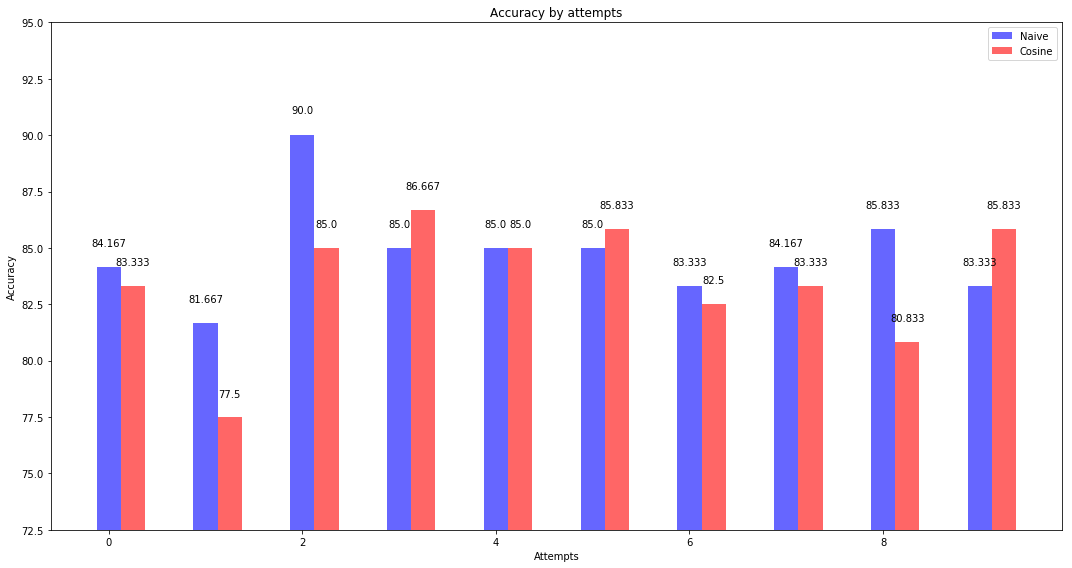

In [20]:
import matplotlib.pyplot as plt
# create plot
fig, ax = plt.subplots(figsize=(15, 8))

# plt.grid(True)
index = np.arange(len(accuracy_cosine))
bar_width = 0.25
opacity = 0.6
 
rects1 = plt.bar(index, accuracy_naive, bar_width,
alpha=opacity,
color='b',
label='Naive')

plt.axis(ymin=min(accuracy_cosine) - 5, ymax= max(accuracy_naive)+5);

rects2 = plt.bar(index + bar_width, accuracy_cosine, bar_width,
alpha=opacity,
color='r',
label='Cosine')


 
plt.xlabel('Attempts')
plt.ylabel('Accuracy')
plt.title('Accuracy by attempts')
# plt.xticks(index + bar_width/2, ('1', '3', '5'))
plt.legend()


# https://matplotlib.org/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")


plt.tight_layout()
plt.show()
